In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras

import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

- Up until now, we’ve used only TensorFlow’s high-level API, tf.keras. 
- But now it’s time to dive deeper into TensorFlow and take a look at its lower-level Python API.
    - This will be useful when you need extra control to write custom loss functions, custom metrics, layers, models, initializers, regularizers, weight constraints, and more.

## A Quick Tour of TensorFlow
- As you know, TensorFlow is a powerful library for numerical computation, particularly well suited and fine-tuned for large-scale Machine Learning (but you could use it for anything else that requires heavy computations). 
- It was developed by the Google Brain team and it powers many of Google’s large-scale services, such as Google Cloud Speech, Google Photos, and Google Search.
- It was open sourced in November 2015, and it is now the most popular Deep Learning library (in terms of citations in papers, adoption in companies, stars on GitHub, etc.). 
- Countless projects use TensorFlow for all sorts of Machine Learning tasks, such as image classification, natural language processing, recommender systems, and time series forecasting.

So what does TensorFlow offer? Here’s a summary:
- Its core is very similar to NumPy, but with GPU support.
- It supports distributed computing (across multiple devices and servers).
- It includes a kind of just-in-time (JIT) compiler that allows it to optimize computations for speed and memory usage. 
    - It works by extracting the computation graph from a Python function, then optimizing it (e.g., by pruning unused nodes), and finally running it efficiently (e.g., by automatically running independent operations in parallel).
- Computation graphs can be exported to a portable format, so you can train a TensorFlow model in one environment (e.g., using Python on Linux) and run it in another (e.g., using Java on an Android device).
- It implements autodiff and provides some excellent optimizers, such as RMSProp and Nadam, so you can easily minimize all sorts of loss functions.

TensorFlow offers many more features built on top of these core features: the most important is of course **tf.keras**, but **it also has data loading and preprocessing ops (tf.data, tf.io, etc.), image processing ops (tf.image), signal processing ops (tf.signal), and more.**

<img src="12-1.png">

- At the lowest level, each TensorFlow operation (op for short) is implemented using highly efficient C++ code.
- Many operations have multiple implementations called **kernels**: each kernel is dedicated to a specific device type, such as CPUs, GPUs, or even TPUs (tensor processing units).
    - As you may know, GPUs can dramatically speed up computations by splitting them into many smaller chunks and running them in parallel across many GPU threads.
    - TPUs are even faster: they are custom ASIC chips built specifically for Deep Learning operations.

TensorFlow’s architecture is shown in Figure 12-2.

- Most of the time your code will use the high-level APIs (especially tf.keras and tf.data); but when you need more flexibility, you will use the lower-level Python API, handling tensors directly.
- Note that APIs for other languages are also available. 
- In any case, TensorFlow’s execution engine will take care of running the operations efficiently, even across multiple devices and machines if you tell it to.
<img src="12-2.png">

- There’s more to TensorFlow than the library. TensorFlow is at the center of an extensive ecosystem of libraries. First, there’s **TensorBoard for visualization.**
    - Next, there’s **TensorFlow Extended (TFX)**, which is a set of libraries built by Google to **productionize TensorFlow projects:** it includes tools for data validation, preprocessing, model analysis, and serving.
    - Google’s **TensorFlow Hub** provides a way to easily **download and reuse pretrained neural networks.**
    - You can also get many **neural network architectures**, some of them pretrained, in **TensorFlow’s model garden.**

## Using TensorFlow like NumPy
- TensorFlow’s API revolves around tensors, which flow from operation to operation hence the name TensorFlow.
    - **A tensor is usually a multidimensional array (exactly like a NumPy ndarray), but it can also hold a scalar (a simple value, such as 42).**

### Tensors and Operations
- **You can create a tensor with tf.constant().** 
    - For example, here is a tensor representing a matrix with two rows and three columns of floats:

In [2]:
tf.constant([[1., 2., 3.], [4., 5., 6.]]) #matrix

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [3]:
tf.constant(42) #scalar

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [4]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
t

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

Just like an ndarray, a tf.Tensor has a shape and a data type (dtype):

In [5]:
t.shape

TensorShape([2, 3])

In [6]:
t.dtype

tf.float32

### Indexing
Indexing works much like in NumPy:

In [7]:
t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [8]:
t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

### Ops
Most importantly, all sorts of tensor operations are available:

In [9]:
t + 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

Note that writing t + 10 is equivalent to calling tf.add(t, 10) (indeed, Python calls the magic method $t.__add__(10)$, which just calls tf.add(t, 10)). Other operators like - and * are also supported.

In [10]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [11]:
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

The **@ operator** was added in Python 3.5, for **matrix multiplication**: it is equivalent to calling the tf.matmul() function.

- You will find all the basic math operations you need (tf.add(), tf.multiply(), tf.square(), tf.exp(), tf.sqrt(), etc.) and most operations that you can find in NumPy (e.g., tf.reshape(), tf.squeeze(), tf.tile()). 
- Some functions have a different name than in NumPy; for instance, **tf.reduce_mean(), tf.reduce_sum(), tf.reduce_max(), and tf.math.log() are the equivalent of np.mean(), np.sum(), np.max() and np.log().**
- When the name differs, there is often a good reason for it.
    - For example, in TensorFlow you must write tf.transpose(t); you cannot just write t.T like in NumPy.
        - The reason is that the tf.transpose() function does not do exactly the same thing as NumPy’s T attribute: in TensorFlow, a new tensor is created with its own copy of the transposed data, while in NumPy, t.T is just a transposed view on the same data.
    - Similarly, the **tf.reduce_sum()** operation is named this way because its GPU kernel (i.e., GPU implementation) uses a reduce algorithm that does not guarantee the order in which the elements are added: because 32-bit floats have limited precision, the result may change ever so slightly every time you call this operation.
    - **The same is true of tf.reduce_mean()** (but of course **tf.reduce_max() is deterministic**).

### KERAS’ LOW-LEVEL API
- The Keras API has its own low-level API, located in **keras.backend.** 
    - It includes functions like **square(), exp(), and sqrt().**
- In tf.keras, these functions generally just call the corresponding TensorFlow operations.
- If you want to write code that will be portable to other Keras implementations, you should use these Keras functions.
- However, they only cover a subset of all functions available in TensorFlow, so we will use the TensorFlow operations directly.

Here is as simple example using keras.backend, which is commonly named K for short:

In [12]:
K = keras.backend
K.square(K.transpose(t)) + 10

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

## Tensors and NumPy
- Tensors play nice with NumPy: you can create a tensor from a NumPy array, and vice versa. 
    - You can even apply TensorFlow operations to NumPy arrays and NumPy operations to tensors:

In [13]:
a = np.array([2., 4., 5.])
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [14]:
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [15]:
np.array(t)

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [16]:
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [17]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

### WARNING
- Notice that NumPy uses 64-bit precision by default, while TensorFlow uses 32-bit. 
    - This is because 32-bit precision is generally more than enough for neural networks, plus it runs faster and uses less RAM. 
- **So when you create a tensor from a NumPy array, make sure to set dtype=tf.float32.**

### Type Conversions
- Type conversions can significantly hurt performance, and they can easily go unnoticed when they are done automatically. 
- **To avoid this, TensorFlow does not perform any type conversions automatically**: it just raises an exception if you try to execute an operation on tensors with incompatible types. 
    - For example, you cannot add a float tensor and an integer tensor, and you cannot even add a 32-bit float and a 64-bit float:

In [18]:
#tf.constant(2.) + tf.constant(40)
try:
    tf.constant(2.0) + tf.constant(40)
except tf.errors.InvalidArgumentError as ex:
    print(ex)
    
#tf.constant(2.) + tf.constant(40., dtype=tf.float64)
try:
    tf.constant(2.0) + tf.constant(40., dtype=tf.float64)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2]
cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:AddV2]


- This may be a bit annoying at first, but remember that it’s for a good cause!
- And of course you can use **tf.cast()** when you really need **to convert types**:

In [19]:
t2 = tf.constant(40., dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

### Variables
- **The tf.Tensor values we’ve seen so far are immutable: you cannot modify them.**
    - This means that we cannot use regular tensors to implement weights in a neural network, since they need to be tweaked by backpropagation.
    - Plus, other parameters may also need to change over time (e.g., a momentum optimizer keeps track of past gradients).
- **What we need is a tf.Variable:**

In [20]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

- A tf.Variable acts much like a tf.Tensor: you can perform the same operations with it, it plays nicely with NumPy as well, and it is just as picky with types.
- But it can also be modified in place using the **assign() method (or assign_add() or assign_sub()**, which increment or decrement the variable by the given value).
- You can also modify individual cells (or slices), **by using the cell’s (or slice’s) assign()** method (direct item assignment will not work) **or by using the scatter_update() or scatter_nd_update()** methods:

In [21]:
v.assign(2 * v) # => [[2., 4., 6.], [8., 10., 12.]]
v[0, 1].assign(42) # => [[2., 42., 6.], [8., 10., 12.]]
v[:, 2].assign([0., 1.]) # => [[2., 42., 0.], [8., 10., 1.]]
v.scatter_nd_update(indices=[[0, 0], [1, 2]], updates=[100., 200.])
# => [[100., 42., 0.], [8., 10., 200.]]

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

In [22]:
try:
    v[1] = [7., 8., 9.]
except TypeError as ex:
    print(ex)

'ResourceVariable' object does not support item assignment


In [23]:
v.scatter_nd_update(indices=[[0, 0], [1, 2]],
                    updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

In [24]:
sparse_delta = tf.IndexedSlices(values=[[1., 2., 3.], [4., 5., 6.]],
                                indices=[1, 0])
v.scatter_update(sparse_delta)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[4., 5., 6.],
       [1., 2., 3.]], dtype=float32)>

### NOTE
In practice you will rarely have to create variables manually, since Keras provides an add_weight() method that will take care of it for you, as we will see. 
Moreover, model parameters will generally be updated directly by the optimizers, so you will rarely need to update variables manually.

### Other Data Structures
### String tensors
- Are regular tensors of type tf.string. 
- These represent byte strings, not Unicode strings, so if you create a string tensor using a Unicode string (e.g., a regular Python 3 string like "café"), then it will get encoded to UTF-8 automatically (e.g., b"caf\xc3\xa9"). 
- Alternatively, you can represent Unicode strings using tensors of type tf.int32, where each item represents a Unicode code point (e.g., [99, 97, 102, 233]). 
- The tf.strings package (with an s) contains ops for byte strings and Unicode strings (and to convert one into the other). 
- It’s important to note that a **tf.string is atomic, meaning that its length does not appear in the tensor’s shape.** 
    - **Once you convert it to a Unicode tensor (i.e., a tensor of type tf.int32 holding Unicode code points), the length appears in the shape.**

In [25]:
tf.constant(b"hello world")

<tf.Tensor: shape=(), dtype=string, numpy=b'hello world'>

In [26]:
tf.constant("café")

<tf.Tensor: shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [27]:
u = tf.constant([ord(c) for c in "café"])
u

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233])>

In [28]:
b = tf.strings.unicode_encode(u, "UTF-8")
tf.strings.length(b, unit="UTF8_CHAR")

<tf.Tensor: shape=(), dtype=int32, numpy=4>

In [29]:
tf.strings.unicode_decode(b, "UTF-8")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233])>

### String arrays

In [30]:
p = tf.constant(["Café", "Coffee", "caffè", "咖啡"])

In [31]:
tf.strings.length(p, unit="UTF8_CHAR")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([4, 6, 5, 2])>

In [32]:
r = tf.strings.unicode_decode(p, "UTF8")
r

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232], [21654, 21857]]>

In [33]:
print(r)

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232], [21654, 21857]]>


### Sparse tensors
- Efficiently represent tensors containing mostly zeros. 
- The tf.sparse package contains operations for sparse tensors.

In [34]:
s = tf.SparseTensor(indices=[[0, 1], [1, 0], [2, 3]],
                    values=[1., 2., 3.],
                    dense_shape=[3, 4])

In [35]:
print(s)

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 0]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [36]:
tf.sparse.to_dense(s)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [2., 0., 0., 0.],
       [0., 0., 0., 3.]], dtype=float32)>

In [37]:
s2 = s * 2.0

In [38]:
try:
    s3 = s + 1.
except TypeError as ex:
    print(ex)

unsupported operand type(s) for +: 'SparseTensor' and 'float'


In [39]:
s4 = tf.constant([[10., 20.], [30., 40.], [50., 60.], [70., 80.]])
tf.sparse.sparse_dense_matmul(s, s4)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 30.,  40.],
       [ 20.,  40.],
       [210., 240.]], dtype=float32)>

In [40]:
s5 = tf.SparseTensor(indices=[[0, 2], [0, 1]],
                     values=[1., 2.],
                     dense_shape=[3, 4])
print(s5)

SparseTensor(indices=tf.Tensor(
[[0 2]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([1. 2.], shape=(2,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [41]:
try:
    tf.sparse.to_dense(s5)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

indices[1] = [0,1] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SparseToDense]


In [42]:
s6 = tf.sparse.reorder(s5)
tf.sparse.to_dense(s6)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 2., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

### Sets
- Are represented as regular tensors (or sparse tensors). 
    - For example, tf.constant([[1, 2], [3, 4]]) represents the two sets {1, 2} and {3, 4}. 
        - More generally, each set is represented by a vector in the tensor’s last axis. 
        - You can manipulate sets using operations from the tf.sets package.

In [43]:
set1 = tf.constant([[2, 3, 5, 7], [7, 9, 0, 0]])
set2 = tf.constant([[4, 5, 6], [9, 10, 0]])
tf.sparse.to_dense(tf.sets.union(set1, set2))

<tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[ 2,  3,  4,  5,  6,  7],
       [ 0,  7,  9, 10,  0,  0]])>

In [44]:
tf.sparse.to_dense(tf.sets.difference(set1, set2))

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[2, 3, 7],
       [7, 0, 0]])>

In [45]:
tf.sparse.to_dense(tf.sets.intersection(set1, set2))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[5, 0],
       [0, 9]])>

### Tensor Arrays
- Are lists of tensors. They have a fixed size by default but can optionally be made dynamic. 
- **All tensors they contain must have the same shape and data type.**

In [46]:
array = tf.TensorArray(dtype=tf.float32, size=3)
array = array.write(0, tf.constant([1., 2.]))
array = array.write(1, tf.constant([3., 10.]))
array = array.write(2, tf.constant([5., 7.]))

In [47]:
array.read(1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 3., 10.], dtype=float32)>

In [48]:
array.stack()

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 2.],
       [0., 0.],
       [5., 7.]], dtype=float32)>

In [49]:
mean, varience = tf.nn.moments(array.stack(), axes=0)
mean

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 3.], dtype=float32)>

In [50]:
varience

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([4.6666665, 8.666667 ], dtype=float32)>

## Customizing Models and Training Algorithms
Let’s start by creating a custom loss function, which is a simple and common use case.

### Custom Loss Functions
- Suppose you want to train a regression model, but your training set is a bit noisy. 
    - Of course, you start by trying to clean up your dataset by removing or fixing the outliers, but that turns out to be insufficient; the dataset is still noisy.
- Which loss function should you use? 
    - The mean squared error might penalize large errors too much and cause your model to be imprecise.
    - The mean absolute error would not penalize outliers as much, but training might take a while to converge, and the trained model might not be very precise.
- This is probably a good time to use the Huber loss instead of the good old MSE.
    - The Huber loss is not currently part of the official Keras API, but it is available in tf.keras (just use an instance of the keras.losses.Huber class).
- But let’s pretend it’s not there: implementing it is easy as pie!
    - Just create a function that takes the labels and predictions as arguments, and use TensorFlow operations to compute every instance’s loss.

Let's start by loading and preparing the California housing dataset. We first load it, then split it into a training set, a validation set and a test set, and finally we scale it:

In [51]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [52]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

### WARNING
- For better performance, you should use a vectorized implementation, as in this example.
- Moreover, **if you want to benefit from TensorFlow’s graph features, you should use only TensorFlow operations.**

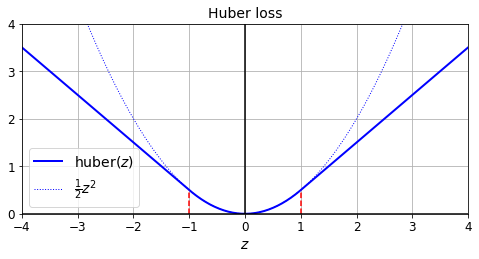

In [53]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [54]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

- It is also preferable to return a tensor containing one loss per instance, rather than returning the mean loss. This way, Keras can apply class weights or sample weights when requested.
- Now you can use this loss when you compile the Keras model, then train your model:

In [55]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [56]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 5ms/step - loss: 1.0443 - mae: 1.4660 - val_loss: 0.2862 - val_mae: 0.5866
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2379 - mae: 0.5407 - val_loss: 0.2382 - val_mae: 0.5281


- And that’s it! For each batch during training, Keras will call the huber_fn() function to compute the loss and use it to perform a Gradient Descent step. 
    - Moreover, it will keep track of the total loss since the beginning of the epoch, and it will display the mean loss.

But what happens to this custom loss when you save the model?

### Saving and Loading Models That Contain Custom Components
- Saving a model containing a custom loss function works fine, as Keras saves the name of the function. Whenever you load it, you’ll need to provide a dictionary that maps the function name to the actual function.
    - More generally, **when you load a model containing custom objects, you need to map the names to the objects:**

In [57]:
model.save("my_model_with_a_custom_loss.h5")

In [58]:
model = keras.models.load_model("my_model_with_a_custom_loss.h5", 
                                custom_objects={"huber_fn": huber_fn})

In [59]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.2054 - mae: 0.4982 - val_loss: 0.2209 - val_mae: 0.5050
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.1999 - mae: 0.4900 - val_loss: 0.2127 - val_mae: 0.4986


With the current implementation, any error between –1 and 1 is considered “small.” But what if you want a different threshold? One solution is to create a function that creates a configured loss function:

In [60]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [61]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [62]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 3ms/step - loss: 0.2318 - mae: 0.4979 - val_loss: 0.2540 - val_mae: 0.4907
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2309 - mae: 0.4960 - val_loss: 0.2372 - val_mae: 0.4879


In [63]:
model.save("my_model_with_a_custom_loss_threshold_2.h5")

- Unfortunately, when you save the model, **the threshold will not be saved.**
- **This means that you will have to specify the threshold value when loading the model (note that the name to use is "huber_fn", which is the name of the function you gave Keras, not the name of the function that created it):**

In [64]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2147 - mae: 0.4800 - val_loss: 0.2133 - val_mae: 0.4654
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2119 - mae: 0.4762 - val_loss: 0.1992 - val_mae: 0.4643


**You can solve this by creating a subclass of the keras.losses.Loss class, and then implementing its get_config() method:**

In [65]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

Let’s walk through this code:

- The constructor accepts **kwargs and passes them to the parent constructor, which handles standard hyperparameters: the name of the loss and the reduction algorithm to use to aggregate the individual instance losses. 
    - By default, it is "sum_over_batch_size", which means that the loss will be the sum of the instance losses, weighted by the sample weights, if any, and divided by the batch size (not by the sum of weights, so this is not the weighted mean). 
    - Other possible values are "sum" and None.
- The call() method takes the labels and predictions, computes all the instance losses, and returns them.
- The get_config() method returns a dictionary mapping each hyperparameter name to its value. 
    - It first calls the parent class’s get_config() method, then adds the new hyperparameters to this dictionary (note that the convenient {**x} syntax was added in Python 3.5).
    
You can then use any instance of this class when you compile the model:

In [66]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [67]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [68]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 1.4306 - mae: 1.4064 - val_loss: 0.4276 - val_mae: 0.6122
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2840 - mae: 0.5465 - val_loss: 0.3437 - val_mae: 0.5537


In [69]:
model.save("my_model_with_a_custom_loss_class.h5")

**When you save the model, the threshold will be saved along with it; and when you load the model, you just need to map the class name to the class itself:**

In [70]:
model = keras.models.load_model("my_model_with_a_custom_loss_class.h5",
                                custom_objects={"HuberLoss": HuberLoss})

In [71]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.2328 - mae: 0.5019 - val_loss: 0.2627 - val_mae: 0.5015
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2234 - mae: 0.4931 - val_loss: 0.2037 - val_mae: 0.4739


In [72]:
model.loss.threshold

2.0

- When you save a model, Keras calls the loss instance’s get_config() method and saves the config as JSON in the HDF5 file. 
- When you load the model, it calls the from_config() class method on the HuberLoss class: this method is implemented by the base class (Loss) and creates an instance of the class, passing **config to the constructor.

### Custom Activation Functions, Initializers, Regularizers, and Constraints
- Most Keras functionalities, such as losses, regularizers, constraints, initializers, metrics, activation functions, layers, and even full models, can be customized in very much the same way. 
    - Most of the time, you will just need to write a simple function with the appropriate inputs and outputs.
- Here are examples of **a custom activation function (equivalent to keras.activations.softplus() or tf.nn.softplus())**, 
    - **a custom Glorot initializer** (equivalent to keras.initializers.glorot_normal()),
    - **a custom ℓ1 regularizer** (equivalent to keras.regularizers.l1(0.01)),
    - and **a custom constraint that ensures weights are all positive (equivalent to keras.constraints.nonneg() or tf.nn.relu()):**

In [73]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [74]:
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

As you can see, the arguments depend on the type of custom function.
These custom functions can then be used normally; for example:

In [75]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

In [76]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [77]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [78]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [79]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 2.3829 - mae: 1.1635 - val_loss: 1.4154 - val_mae: 0.5607
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.6299 - mae: 0.5410 - val_loss: 1.4399 - val_mae: 0.5137


- The activation function will be applied to the output of this Dense layer, and its result will be passed on to the next layer. 
    - The layer’s weights will be initialized using the value returned by the initializer. 
    - At each training step the weights will be passed to the regularization function to compute the regularization loss, which will be added to the main loss to get the final loss used for training. 
    - Finally, the constraint function will be called after each training step, and the layer’s weights will be replaced by the constrained weights.
- If a function has hyperparameters that need to be saved along with the model, then you will want to subclass the appropriate class, such as keras.regularizers.Regularizer, keras.constraints.Constraint, keras.initializers.Initializer, or keras.layers.Layer (for any layer, including activation functions).


In [80]:
model.save("my_model_with_many_custom_parts.h5")

In [81]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

- Much like we did for the custom loss, here is a simple class for ℓ1 regularization that saves its factor hyperparameter (this time we do not need to call the parent constructor or the get_config() method, as they are not defined by the parent class):

In [82]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}

In [83]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [84]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [85]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [86]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 2.3829 - mae: 1.1635 - val_loss: 1.4154 - val_mae: 0.5607
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.6299 - mae: 0.5410 - val_loss: 1.4399 - val_mae: 0.5137


In [87]:
model.save("my_model_with_many_custom_parts.h5")

In [88]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

- Note that **you must implement the call() method for losses, layers (including activation functions), and models**, or **the __call__() method for regularizers, initializers, and constraints.**

For metrics, things are a bit different, as we will see now.

### Custom Metrics
- Losses and metrics are conceptually not the same thing: **losses (e.g., cross entropy) are used by Gradient Descent to train a model**, so they must be differentiable (at least where they are evaluated), and their gradients should not be 0 everywhere.
    - Plus, it’s OK if they are not easily interpretable by humans.
- In contrast, **metrics (e.g., accuracy) are used to evaluate a model**: they must be more easily interpretable, and they can be non-differentiable or have 0 gradients everywhere.
- That said, in most cases, defining a custom metric function is exactly the same as defining a custom loss function. 
    - In fact, we could even use the Huber loss function we created earlier as a metric; it would work just fine (and persistence would also work the same way, in this case only saving the name of the function, "huber_fn"): 

In [89]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [90]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [91]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [92]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 3.5903 - huber_fn: 1.5558
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.8054 - huber_fn: 0.3095


In [93]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[create_huber(2.0)])

In [94]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.1245 - huber_fn: 0.2515
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1216 - huber_fn: 0.2473


In [95]:
history.history["loss"][0], history.history["huber_fn"][0] * sample_weight.mean()

(0.11749907582998276, 0.11906625573138947)

### Note:
- If you use the same function as the loss and a metric, you may be surprised to see different results. 
- This is generally just due to floating point precision errors: even though the mathematical equations are equivalent, the operations are not run in the same order, which can lead to small differences. Moreover, when using sample weights, there's more than just precision errors:
    - The loss since the start of the epoch is the mean of all batch losses seen so far. 
        - Each batch loss is the sum of the weighted instance losses divided by the batch size (not the sum of weights, so the batch loss is not the weighted mean of the losses).
    - The metric since the start of the epoch is equal to the sum of weighted instance losses divided by sum of all weights seen so far. 
        - In other words, it is the weighted mean of all the instance losses. Not the same thing.

If you do the math, you will find that loss = metric * mean of sample weights (plus some floating point precision error).

### Streaming metrics
- Suppose the model made five positive predictions in the first batch, four of which were correct: that’s 80% precision. 
    - Then suppose the model made three positive predictions in the second batch, but they were all incorrect: that’s 0% precision for the second batch. If you just compute the mean of these two precisions, you get 40%.
- But wait a second—that’s not the model’s precision over these two batches!
    - **Indeed, there were a total of four true positives (4 + 0) out of eight positive predictions (5 + 3), so the overall precision is 50%, not 40%.** 
    - What we need is an object that can keep track of the number of true positives and the number of false positives and that can compute their ratio when requested.
    
This is precisely what the **keras.metrics.Precision** class does:

In [96]:
precision = keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [97]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

- In this example, we created a Precision object, then we used it like a function, passing it the labels and predictions for the first batch, then for the second batch (note that we could also have passed sample weights).
- We used the same number of true and false positives as in the example we just discussed. 
    - After the first batch, it returns a precision of 80%; 
    - then after the second batch, it returns 50% **(which is the overall precision so far, not the second batch’s precision).**
- This is called a **streaming metric** (or stateful metric), as it is gradually updated, batch after batch.
- At any point, we can call the **result() method to get the current value of the metric.** 
- We can also look at its variables (tracking the number of true and false positives) by using the **variables attribute**, and we can reset these variables using the **reset_states()** method:

In [98]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [99]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [100]:
precision.reset_states() # both variables get reset to 0.0

- If you need to create such a streaming metric, create a subclass of the keras.metrics.Metric class. Here is a simple example that keeps track of the total Huber loss and the number of instances seen so far. 
- When asked for the result, it returns the ratio, which is simply the mean Huber loss:

In [101]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

#### This class is for illustration purposes only. A simpler and better implementation would just subclass the keras.metrics.Mean class;
Let’s walk through this code:
- The constructor uses the add_weight() method to create the variables needed to keep track of the metric’s state over multiple batches—in this case, the sum of all Huber losses (total) and the number of instances seen so far (count). 
    - You could just create variables manually if you preferred. 
    - Keras tracks any tf.Variable that is set as an attribute (and more generally, any “trackable” object, such as layers or models).
- The update_state() method is called when you use an instance of this class as a function (as we did with the Precision object). 
    - It updates the variables, given the labels and predictions for one batch (and sample weights, but in this case we ignore them).
- The result() method computes and returns the final result, in this case the mean Huber metric over all instances. 
    - When you use the metric as a function, the update_state() method gets called first, then the result() method is called, and its output is returned.
- We also implement the get_config() method to ensure the threshold gets saved along with the model.
- The default implementation of the reset_states() method resets all variables to 0.0 (but you can override it if needed).

In [102]:
m = HuberMetric(2.)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]]))

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [103]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [104]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=21.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [105]:
m.reset_states()
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

Let's check that the HuberMetric class works well:

In [106]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [107]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [108]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[HuberMetric(2.0)])

In [109]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 1.5182 - huber_metric: 1.5182
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2909 - huber_metric: 0.2909


In [110]:
model.save("my_model_with_a_custom_metric.h5")

In [111]:
model = keras.models.load_model("my_model_with_a_custom_metric.h5",
                                custom_objects={"huber_fn": create_huber(2.0),
                                                "HuberMetric": HuberMetric})

In [112]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2350 - huber_metric: 0.2350
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2278 - huber_metric: 0.2278


### Warning: 
In TF 2.2, tf.keras adds an extra first metric in model.metrics at position 0 (see TF issue #38150). This forces us to use model.metrics[-1] rather than model.metrics[0] to access the HuberMetric.

In [113]:
model.metrics[-1].threshold

2.0

Looks like it works fine! More simply, we could have created the class like this:

In [114]:
class HuberMetric(keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

This class handles shapes better, and it also supports sample weights.

In [115]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [116]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [117]:
model.compile(loss=keras.losses.Huber(2.0), optimizer="nadam", weighted_metrics=[HuberMetric(2.0)])

In [118]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32),
                    epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.7800 - HuberMetric: 1.5672
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1462 - HuberMetric: 0.2939


In [119]:
history.history["loss"][0], history.history["HuberMetric"][0] * sample_weight.mean()

(0.44554394483566284, 0.44554404180100277)

In [120]:
model.save("my_model_with_a_custom_metric_v2.h5")

In [121]:
model = keras.models.load_model("my_model_with_a_custom_metric_v2.h5",
                                custom_objects={"HuberMetric": HuberMetric})

In [122]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2377 - HuberMetric: 0.2377
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2279 - HuberMetric: 0.2279


In [123]:
model.metrics[-1].threshold

2.0

- When you define a metric using a simple function, Keras automatically calls it for each batch, and it keeps track of the mean during each epoch, just like we did manually. 
    - So the only benefit of our HuberMetric class is that the threshold will be saved. 
    - But of course, some metrics, like precision, cannot simply be averaged over batches: in those cases, there’s no other option than to implement a streaming metric.

### Custom Layers
- You may occasionally want to build an architecture that contains an exotic layer for which TensorFlow does not provide a default implementation. 
    - In this case, you will need to create a custom layer. Or you may simply want to build a very repetitive architecture, containing identical blocks of layers repeated many times, and it would be convenient to treat each block of layers as a single layer. For example, if the model is a sequence of layers A, B, C, A, B, C, A, B, C, then you might want to define a custom layer D containing layers A, B, C, so your model would then simply be D, D, D.
    
Let’s see how to build custom layers.
- First, some layers have no weights, such as keras.layers.Flatten or keras.layers.ReLU. 
    - If you want to create a custom layer without any weights, the simplest option is to write a function and wrap it in a keras.layers.Lambda layer. 

For example, the following layer will apply the exponential function to its inputs:

In [124]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

Adding an exponential layer at the output of a regression model can be useful if the values to predict are positive and with very different scales (e.g., 0.001, 10., 10000):

In [125]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [126]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 2.1275 - val_loss: 0.4457
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4750 - val_loss: 0.3798
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4230 - val_loss: 0.3548
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.3905 - val_loss: 0.3464
Epoch 5/5
162/162 [==============================] - 0s 1ms/step - loss: 0.3586


0.3586341440677643

- This custom layer can then be used like any other layer, using the Sequential API, the Functional API, or the Subclassing API. 
    - You can also use it as an activation function (or you could use activation=tf.exp, activation=keras.activations.exponential, or simply activation="exponential"). 
    - The exponential layer is sometimes used in the output layer of a regression model when the values to predict have very different scales (e.g., 0.001, 10., 1,000.).
- As you’ve probably guessed by now, to build a custom stateful layer (i.e., a layer with weights), you need to create a subclass of the keras.layers.Layer class. 

For example, the following class implements a simplified version of the Dense layer:

In [127]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

Let’s walk through this code:
- The constructor takes all the hyperparameters as arguments (in this example, units and activation), and importantly it also takes a **kwargs argument. 
    - It calls the parent constructor, passing it the kwargs: this takes care of standard arguments such as input_shape, trainable, and name. 
    - Then it saves the hyperparameters as attributes, converting the activation argument to the appropriate activation function using the keras.activations.get() function (it accepts functions, standard strings like "relu" or "selu", or simply None).
- The build() method’s role is to create the layer’s variables by calling the add_weight() method for each weight. 
    - The build() method is called the first time the layer is used. 
    - At that point, Keras will know the shape of this layer’s inputs, and it will pass it to the build() method, which is often necessary to create some of the weights. 
    - For example, we need to know the number of neurons in the previous layer in order to create the connection weights matrix (i.e., the "kernel"): this corresponds to the size of the last dimension of the inputs. 
    - At the end of the build() method (and only at the end), you must call the parent’s build() method: this tells Keras that the layer is built (it just sets self.built=True).
- The call() method performs the desired operations. 
    - In this case, we compute the matrix multiplication of the inputs X and the layer’s kernel, we add the bias vector, and we apply the activation function to the result, and this gives us the output of the layer.
- The compute_output_shape() method simply returns the shape of this layer’s outputs. In this case, it is the same shape as the inputs, except the last dimension is replaced with the number of neurons in the layer. 
    - Note that in tf.keras, shapes are instances of the tf.TensorShape class, which you can convert to Python lists using as_list().
- The get_config() method is just like in the previous custom classes. 
    - Note that we save the activation function’s fullconfiguration by calling keras.activations.serialize().

You can now use a MyDense layer just like any other layer!

In [128]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [129]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

In [130]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 4.1268 - val_loss: 0.9472
Epoch 2/2
162/162 [==============================] - 0s 1ms/step - loss: 0.5474


0.5473727583885193

In [131]:
model.save("my_model_with_a_custom_layer.h5")

In [132]:
model = keras.models.load_model("my_model_with_a_custom_layer.h5",
                                custom_objects={"MyDense": MyDense})

- To create a layer with multiple inputs (e.g., Concatenate), the argument to the call() method should be a tuple containing all the inputs, and similarly the argument to the compute_output_shape() method should be a tuple containing each input’s batch shape. 
- To create a layer with multiple outputs, the call() method should return the list of outputs, and compute_output_shape() should return the list of batch output shapes (one per output). 

For example, the following toy layer takes two inputs and returns three outputs:

In [133]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        return X1 + X2, X1 * X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]

This layer may now be used like any other layer, but of course only using the Functional and Subclassing APIs, not the Sequential API (which only accepts layers with one input and one output).

In [134]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [135]:
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

- If your layer needs to have a different behavior during training and during testing (e.g., if it uses Dropout or BatchNormalization layers), then you must add a training argument to the call() method and use this argument to decide what to do.

For example, let’s create a layer that adds Gaussian noise during training (for regularization) but does nothing during
testing (Keras has a layer that does the same thing, keras.layers.GaussianNoise):

In [136]:
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

In [137]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.5496 - val_loss: 0.5329
Epoch 2/2
162/162 [==============================] - 0s 1ms/step - loss: 0.3990


0.3990039527416229

### Custom Models
Suppose you want to build the model represented in Figure 12-3.

<img src="12-3.png">

- The inputs go through a first dense layer, then through a residual block composed of two dense layers and an addition operation, then through this same residual block three more times, then through a second residual block, and the final result goes through a dense output layer. 
    - **Note that this model does not make much sense; it’s just an example to illustrate the fact that you can easily build any kind of model you want, even one that contains loops and skip connections.** 
- To implement this model, it is best to first create a ResidualBlock layer, since we are going to create a couple of identical blocks (and we might want to reuse it in another model):

In [138]:
X_new_scaled = X_test_scaled

In [139]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

- This layer is a bit special since it contains other layers. 
- This is handled transparently by Keras: it automatically detects that the hidden attribute contains trackable objects (layers in this case), so their variables are automatically added to this layer’s list of variables. 
    - The rest of this class is self-explanatory. 
    - Next, let’s use the Subclassing API to define the model itself:

In [140]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [141]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

- The Model class is a subclass of the Layer class, so models can be defined and used exactly like layers. 
- But a model has some extra functionalities, including of course its compile(), fit(), evaluate(), and predict() methods (and a few variants), plus the get_layers() method (which can return any of the model’s layers by name or by index) and the save() method (and support for keras.models.load_model() and keras.models.clone_model()).
***
- With that, you can naturally and concisely build almost any model that you find in a paper, using the Sequential API, the Functional API, the Subclassing API, or even a mix of these. 
    - “Almost” any model? Yes, there are still a few things that we need to look at: first, how to define losses or metrics based on model internals, and second, how to build a custom training loop.

In [142]:
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - ETA: 0s - loss: 23.09 - 3s 3ms/step - loss: 22.7478
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 1.2735
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.9790
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.5911
Epoch 5/5
162/162 [==============================] - 0s 1ms/step - loss: 0.6489


In [143]:
model.save("my_custom_model.ckpt")

INFO:tensorflow:Assets written to: my_custom_model.ckpt\assets


INFO:tensorflow:Assets written to: my_custom_model.ckpt\assets


In [144]:
model = keras.models.load_model("my_custom_model.ckpt")

In [145]:
history = model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 3s 2ms/step - loss: 0.9472
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.6948
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4790
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4297
Epoch 5/5
363/363 [==============================] - 1s 2ms/step - loss: 0.5894


We could have defined the model using the sequential API instead:

In [146]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [147]:
block1 = ResidualBlock(2, 30)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])

In [148]:
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 3s 2ms/step - loss: 1.5508
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.5562
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.6406
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.3759
Epoch 5/5
162/162 [==============================] - 0s 1ms/step - loss: 0.4852


### Losses and Metrics Based on Model Internals
- The custom losses and metrics we defined earlier were all based on the labels and the predictions (and optionally sample weights). 
    - There will be times when you want to define losses based on other parts of your model, such as the weights or activations of its hidden layers. 
    - This may be useful for regularization purposes or to monitor some internal aspect of your model.
- To define a custom loss based on model internals, compute it based on any part of the model you want, then pass the result to the add_loss() method.
- For example, let’s build a custom regression MLP model composed of a stack of five hidden layers plus an output layer.
    - This custom model will also have an auxiliary output on top of the upper hidden layer.
    - The loss associated to this auxiliary output will be called the **reconstruction loss**: it is the mean squared difference between the reconstruction and the inputs.
    - By adding this reconstruction loss to the main loss, we will encourage the model to preserve as much information as possible through the hidden layers even information that is not directly useful for the regression task itself.
    - In practice, this loss sometimes improves generalization (it is a **regularization loss**). 

Here is the code for this custom model with a custom reconstruction loss:

In [149]:
class ReconstructingRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        self.reconstruct = keras.layers.Dense(8) # workaround for TF issue #46858
        self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss)
        if training:
            result = self.reconstruction_mean(recon_loss)
            self.add_metric(result)
        return self.out(Z)

In [150]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [151]:
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
y_pred = model.predict(X_test_scaled)

Epoch 1/2
363/363 [==============================] - 3s 2ms/step - loss: 1.6313 - reconstruction_error: 1.0474
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.4536 - reconstruction_error: 0.4022


### Computing Gradients Using Autodiff
To understand how to use autodiff to compute gradients automatically, let’s consider a simple toy function:

In [152]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

- If you know calculus, you can analytically find that the partial derivative of this function with regard to **w1 is 6 * w1 + 2 * w2.**
    - You can also find that its partial derivative with regard to **w2 is 2 * w1.**
    - For example, at the point (w1, w2) = (5, 3), these partial derivatives are equal to 36 and 10, respectively, so the gradient vector at this point is (36, 10).
- But if this were a neural network, the function would be much more complex, typically with tens of thousands of parameters, and finding the partial derivatives analytically by hand would be an almost impossible task.
    - One solution could be to compute an approximation of each partial derivative by measuring how much the function’s output changes when you tweak the corresponding parameter:

In [153]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [154]:
(f(w1, w2 + eps) - f(w1, w2)) / eps

10.000000003174137

Looks about right! 
- This works rather well and is easy to implement, but it is just an approximation, and importantly **you need to call f() at least once per parameter** (not twice, since we could compute f(w1, w2) just once).
- **Needing to call f() at least once per parameter makes this approach intractable for large neural networks.** 
    - **So instead, we should use autodiff**. TensorFlow makes this pretty simple:

In [155]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)
    
gradients = tape.gradient(z, [w1, w2])

- We first define two variables w1 and w2, then we create a tf.GradientTape context that will automatically record every operation that involves a variable, and finally we ask this tape to compute the gradients of the result z with regard to both variables [w1, w2]. Let’s take a look at the gradients that TensorFlow computed:

In [156]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

- Perfect! Not only is the result accurate (the precision is only limited by the floating-point errors), but the gradient() method only goes through the recorded computations once (in reverse order), no matter how many variables there are, so it is incredibly efficient. It’s like magic!

In [157]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
try:
    dz_dw2 = tape.gradient(z, w2)
except RuntimeError as ex:
    print(ex)

A non-persistent GradientTape can only be used tocompute one set of gradients (or jacobians)


- If you need to call gradient() more than once, you must make the tape persistent and delete it each time you are done with it to free resources:

In [158]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2) 
del tape

In [159]:
dz_dw1, dz_dw2

(<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

- By default, the tape will only track operations involving variables, so if you try to compute the gradient of z with regard to anything other than a variable, the result will be None:

In [160]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [161]:
gradients

[None, None]

- However, you can force the tape to watch any tensors you like, to record every operation that involves them. 
    - You can then compute gradients with regard to these tensors, as if they were variables:

In [162]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [163]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

- This can be useful in some cases, like if you want to implement a regularization loss that penalizes activations that vary a lot when the inputs vary little: the loss will be based on the gradient of the activations with regard to the inputs. 
    - Since the inputs are not variables, you would need to tell the tape to watch them.
- **Most of the time a gradient tape is used to compute the gradients of a single value (usually the loss) with regard to a set of values (usually the model parameters).**
- This is where **reverse-mode autodiff** shines, **as it just needs to do one forward pass and one reverse pass to get all the gradients at once.**
- If you try to compute the gradients of a vector, for example a vector containing multiple losses, then TensorFlow will compute the gradients of the vector’s sum.
    - So **if you ever need to get the individual gradients** (e.g., the gradients of each loss with regard to the model parameters), **you must call the tape’s jabobian() method: it will perform reverse-mode autodiff once for each loss in the vector (all in parallel by default).**
    - **It is even possible to compute second-order partial derivatives (the Hessians**, i.e., the partial derivatives of the partial derivatives), but this is rarely needed in practice.

In [164]:
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tape.gradient([z1, z2, z3], [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [165]:
with tf.GradientTape(persistent=True) as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tf.reduce_sum(tf.stack([tape.gradient(z, [w1, w2]) for z in (z1, z2, z3)]), axis=0)
del tape

In [166]:
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]
del hessian_tape

In [167]:
jacobians

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [168]:
hessians

[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]

- In some cases you may want to stop gradients from backpropagating through some part of your neural network. 
    - To do this, you must use the **tf.stop_gradient()** function. 
    - The function returns its inputs during the forward pass (like tf.identity()), but it does not let gradients through during backpropagation (it acts like a constant):

In [169]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

- Finally, you may occasionally run into some numerical issues when computing gradients. 
    - For example, if you compute the gradients of the my_softplus() function for large inputs, the result will be NaN:

In [170]:
x = tf.Variable(100.)
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(), dtype=float32, numpy=nan>]

- This is because computing the gradients of this function using autodiff leads to some numerical difficulties: due to floating-point precision errors, autodiff ends up computing infinity divided by infinity (which returns NaN). 
    - Fortunately, we can analytically find that the derivative of the softplus function is just 1 / (1 + 1 / exp(x)), which is numerically stable.

In [171]:
tf.math.log(tf.exp(tf.constant(30., dtype=tf.float32)) + 1.)

<tf.Tensor: shape=(), dtype=float32, numpy=30.0>

In [172]:
x = tf.Variable([100.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>]

- Next, we can tell TensorFlow to use this stable function when computing the gradients of the my_softplus() function by decorating it with **@tf.custom_gradient** and making it return both its normal output and the function that computes the derivatives (note that it will receive as input the gradients that were backpropagated so far, down to the softplus function; and according to the chain rule, we should multiply them with this function’s gradients):

In [173]:
@tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1 / exp)
    return tf.math.log(exp + 1), my_softplus_gradients

- Now when we compute the gradients of the my_better_softplus() function, we get the proper result, even for large input values (however, the main output still explodes because of the exponential; one workaround is to **use tf.where() to return the inputs when they are large**).

In [174]:
def my_better_softplus(z):
    return tf.where(z > 30., z, tf.math.log(tf.exp(z) + 1.))

In [175]:
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_better_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>])

## TensorFlow Functions and Graphs
### TensorFlow Functions
- In TensorFlow 1, graphs were unavoidable (as were the complexities that came with them) because they were a central part of TensorFlow’s API. 
- In TensorFlow 2, they are still there, but not as central, and they’re much (much!) simpler to use. 

To show just how simple, let’s start with a trivial function that computes the cube of its input:

In [176]:
def cube(x):
    return x ** 3

We can obviously call this function with a Python value, such as an int or a float, or we can call it with a tensor:

In [177]:
cube(2)

8

In [178]:
cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

**Now, let’s use tf.function() to convert this Python function to a TensorFlow Function:**

In [179]:
tf_cube = tf.function(cube)
tf_cube

This TF Function can then be used exactly like the original Python function, and it will return the same result (but as tensors):

In [180]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [181]:
tf_cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

### TF Functions and Concrete Functions

In [182]:
concrete_function = tf_cube.get_concrete_function(tf.constant(2.0))
concrete_function.graph

In [183]:
concrete_function(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [184]:
concrete_function is tf_cube.get_concrete_function(tf.constant(2.0))

True

### Exploring Function Definitions and Graphs

In [185]:
concrete_function.graph

In [186]:
ops = concrete_function.graph.get_operations()
ops

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'pow/y' type=Const>,
 <tf.Operation 'pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [187]:
pow_op = ops[2]
list(pow_op.inputs)

[<tf.Tensor 'x:0' shape=() dtype=float32>,
 <tf.Tensor 'pow/y:0' shape=() dtype=float32>]

In [188]:
pow_op.outputs

[<tf.Tensor 'pow:0' shape=() dtype=float32>]

In [189]:
concrete_function.graph.get_operation_by_name('x')

<tf.Operation 'x' type=Placeholder>

In [190]:
concrete_function.graph.get_tensor_by_name('Identity:0')

<tf.Tensor 'Identity:0' shape=() dtype=float32>

In [191]:
concrete_function.function_def.signature

name: "__inference_cube_154443"
input_arg {
  name: "x"
  type: DT_FLOAT
}
output_arg {
  name: "identity"
  type: DT_FLOAT
}

### How TF Functions Trace Python Functions to Extract Their Computation Graphs
- Under the hood, tf.function() analyzed the computations performed by the cube() function and generated an equivalent computation graph! 
    - As you can see, it was rather painless.
- Alternatively, **we could have used tf.function as a decorator**; this is actually more common:

In [192]:
@tf.function
def tf_cube(x):
    print("print: ", x)
    return x ** 3

In [193]:
result = tf_cube(tf.constant(2.0))

print:  Tensor("x:0", shape=(), dtype=float32)


In [194]:
result

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [195]:
result = tf_cube(2)
result = tf_cube(3)
result = tf_cube(tf.constant([[1., 2.]])) # New shape: trace!
result = tf_cube(tf.constant([[3., 4.], [5., 6.]])) # New shape: trace!
result = tf_cube(tf.constant([[7., 8.], [9., 10.], [11., 12.]])) # New shape: trace!

print:  2
print:  3
print:  Tensor("x:0", shape=(1, 2), dtype=float32)
print:  Tensor("x:0", shape=(2, 2), dtype=float32)


print:  Tensor("x:0", shape=(3, 2), dtype=float32)


- TensorFlow optimizes the computation graph, pruning unused nodes, simplifying expressions (e.g., 1 + 2 would get replaced with 3), and more.
- Once the optimized graph is ready, the TF Function efficiently executes the operations in the graph, in the appropriate order (and in parallel when it can). 
    - As a result, **a TF Function will usually run much faster than the original Python function, especially if it performs complex computations.**
- When you want to boost a Python function, just transform it into a TF Function. That’s all!
- Moreover, **when you write a custom loss function, a custom metric, a custom layer, or any other custom function and you use it in a Keras model , Keras automatically converts your function into a TF Function—no need to use tf.function().** 
    - So most of the time, all this magic is 100% transparent.

It is also possible to specify a particular input signature:

In [196]:
@tf.function(input_signature=[tf.TensorSpec([None, 28, 28], tf.float32)])
def shrink(images):
    print("Tracing", images)
    return images[:, ::2, ::2] # drop half the rows and columns

In [197]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [198]:
img_batch_1 = tf.random.uniform(shape=[100, 28, 28])
img_batch_2 = tf.random.uniform(shape=[50, 28, 28])
preprocessed_images = shrink(img_batch_1) # Traces the function.
preprocessed_images = shrink(img_batch_2) # Reuses the same concrete function.

Tracing Tensor("images:0", shape=(None, 28, 28), dtype=float32)


In [199]:
img_batch_3 = tf.random.uniform(shape=[2, 2, 2])
try:
    preprocessed_images = shrink(img_batch_3)  # rejects unexpected types or shapes
except ValueError as ex:
    print(ex)

Python inputs incompatible with input_signature:
  inputs: (
    tf.Tensor(
[[[0.7413678  0.62854624]
  [0.01738465 0.3431449 ]]

 [[0.51063764 0.3777541 ]
  [0.07321596 0.02137029]]], shape=(2, 2, 2), dtype=float32))
  input_signature: (
    TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None))


### Using Autograph To Capture Control Flow
So how does TensorFlow generate graphs?
- It starts by analyzing the Python function’s source code to capture all the control flow statements, such as for loops, while loops, and if statements, as well as break, continue, and return statements. 
    - **This first step is called AutoGraph.**
- The reason TensorFlow has to analyze the source code is that Python does not provide any other way to capture control flow statements: it offers magic methods like __add__() and __mul__() to capture operators like + and *, but there are no __while__() or __if__() magic methods.
- After analyzing the function’s code, AutoGraph outputs an upgraded version of that function in which all the control flow statements are replaced by the appropriate TensorFlow operations, such as tf.while_loop() for loops and tf.cond() for if statements.

A "static" for loop using range():

In [200]:
@tf.function
def add_10(x):
    for i in range(10):
        x += 1
    return x

In [201]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [202]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'add/y' type=Const>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'add_1/y' type=Const>,
 <tf.Operation 'add_1' type=AddV2>,
 <tf.Operation 'add_2/y' type=Const>,
 <tf.Operation 'add_2' type=AddV2>,
 <tf.Operation 'add_3/y' type=Const>,
 <tf.Operation 'add_3' type=AddV2>,
 <tf.Operation 'add_4/y' type=Const>,
 <tf.Operation 'add_4' type=AddV2>,
 <tf.Operation 'add_5/y' type=Const>,
 <tf.Operation 'add_5' type=AddV2>,
 <tf.Operation 'add_6/y' type=Const>,
 <tf.Operation 'add_6' type=AddV2>,
 <tf.Operation 'add_7/y' type=Const>,
 <tf.Operation 'add_7' type=AddV2>,
 <tf.Operation 'add_8/y' type=Const>,
 <tf.Operation 'add_8' type=AddV2>,
 <tf.Operation 'add_9/y' type=Const>,
 <tf.Operation 'add_9' type=AddV2>,
 <tf.Operation 'Identity' type=Identity>]

A "dynamic" loop using tf.while_loop():

In [203]:
@tf.function
def add_10(x):
    condition = lambda i, x: tf.less(i, 10)
    body = lambda i, x: (tf.add(i, 1), tf.add(x, 1))
    final_i, final_x = tf.while_loop(condition, body, [tf.constant(0), x])
    return final_x

In [204]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [205]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

A "dynamic" for loop using tf.range() (captured by autograph):

In [206]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x = x + 1
    return x

In [207]:
add_10.get_concrete_function(tf.constant(0)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'range/start' type=Const>,
 <tf.Operation 'range/limit' type=Const>,
 <tf.Operation 'range/delta' type=Const>,
 <tf.Operation 'range' type=Range>,
 <tf.Operation 'sub' type=Sub>,
 <tf.Operation 'floordiv' type=FloorDiv>,
 <tf.Operation 'mod' type=FloorMod>,
 <tf.Operation 'zeros_like' type=Const>,
 <tf.Operation 'NotEqual' type=NotEqual>,
 <tf.Operation 'Cast' type=Cast>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'zeros_like_1' type=Const>,
 <tf.Operation 'Maximum' type=Maximum>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

### Handling Variables and Other Resources in TF Functions

In [208]:
counter = tf.Variable(0)

@tf.function
def increment(counter, c=1):
    return counter.assign_add(c)

In [209]:
increment(counter)
increment(counter)

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [210]:
function_def = increment.get_concrete_function(counter).function_def
function_def.signature.input_arg[0]

name: "counter"
type: DT_RESOURCE

In [211]:
counter = tf.Variable(0)

@tf.function
def increment(c=1):
    return counter.assign_add(c)

In [212]:
increment()
increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [213]:
function_def = increment.get_concrete_function().function_def
function_def.signature.input_arg[0]

name: "assignaddvariableop_resource"
type: DT_RESOURCE

In [214]:
class Counter:
    def __init__(self):
        self.counter = tf.Variable(0)

    @tf.function
    def increment(self, c=1):
        return self.counter.assign_add(c)

In [215]:
c = Counter()
c.increment()
c.increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [216]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x += 1
    return x

print(tf.autograph.to_code(add_10.python_function))

def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



### Using TF Functions with tf.keras (or Not)¶
**By default, tf.keras will automatically convert your custom code into TF Functions, no need to use tf.function():**

In [217]:
# Custom loss function
def my_mse(y_true, y_pred):
    print("Tracing loss my_mse()")
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [218]:
# Custom metric function
def my_mae(y_true, y_pred):
    print("Tracing metric my_mae()")
    return tf.reduce_mean(tf.abs(y_pred - y_true))

In [219]:
# Custom layer
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        self.biases = self.add_weight(name='bias', 
                                      shape=(self.units,),
                                      initializer='zeros',
                                      trainable=True)
        super().build(input_shape)

    def call(self, X):
        print("Tracing MyDense.call()")
        return self.activation(X @ self.kernel + self.biases)

In [220]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [221]:
# Custom model
class MyModel(keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = MyDense(30, activation="relu")
        self.hidden2 = MyDense(30, activation="relu")
        self.output_ = MyDense(1)

    def call(self, input):
        print("Tracing MyModel.call()")
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [222]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

In [223]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
351/363 [============================>.] - ETA: 0s - loss: 2.8288 - my_mae: 1.2623Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
363/363 [==============================] - 3s 3ms/step - loss: 2.7755 - my_mae: 1.2455 - val_loss: 0.5569 - val_my_mae: 0.4819
Epoch 2/2
162/162 [==============================] - 0s 2ms/step - loss: 0.4164 - my_mae: 0.4639


[0.4163525104522705, 0.4639028012752533]

You can turn this off by creating the model with dynamic=True (or calling super().__init_ _(dynamic=True, **kwargs) in the model's constructor):

In [224]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [225]:
model = MyModel(dynamic=True)

In [226]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

Not the custom code will be called at each iteration. Let's fit, validate and evaluate with tiny datasets to avoid getting too much output:

In [227]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()


[5.507260322570801, 2.0566811561584473]

Alternatively, you can compile a model with run_eagerly=True:

In [228]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [229]:
model = MyModel()

In [230]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae], run_eagerly=True)

In [231]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()


[5.507260322570801, 2.0566811561584473]